In [2]:
%reset -f


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

####
'Arcpy prep to calculate trend datapoints'
####

import shutil
import os
import arcpy
import pandas as pd
import numpy as np


projDIR = r'C:\Users\afullhart\Documents\ArcGIS\Projects'
saveDIR = r'C:\Users\afullhart\Google Drive\Colab Notebooks\FigureParTrends'

arcpy.env.overwriteOutput = True


gcmLabels = ['CCSM4', 'CanESM2', 'MIROC5']
var_labels = ['mean', 'sdev', 'skew', 'mx5p']
year_labels = ['1974_2013', '2000_2029', '2010_2039', '2020_2049', '2030_2059', '2040_2069', '2050_2079', '2060_2089', '2070_2099']

ndays = [31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
ndaysw = [str(x/365.25) for x in ndays]

outputCoordinateSystem = 'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'
parallelProcessingFactor = '5'
extent = '-121.0 30.0 -102.0 43.0 GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]'

gcm_datapoints = []
for gcm in gcmLabels:

  gdbDIR = os.path.join(projDIR, gcm, gcm + '.gdb')
  arcpy.env.workspace = gdbDIR
  var_datapoints = []

  for var in var_labels:

    datapoints = []

    for yrl in year_labels:

      with arcpy.EnvManager(outputCoordinateSystem=outputCoordinateSystem, extent=extent, parallelProcessingFactor=parallelProcessingFactor):

        output_raster = arcpy.sa.RasterCalculator(
          rasters=['{}_{}/Band_1'.format(var, yrl), '{}_{}/Band_2'.format(var, yrl), '{}_{}/Band_3'.format(var, yrl), '{}_{}/Band_4'.format(var, yrl), '{}_{}/Band_5'.format(var, yrl), '{}_{}/Band_6'.format(var, yrl) ,'{}_{}/Band_7'.format(var, yrl), '{}_{}/Band_8'.format(var, yrl), '{}_{}/Band_9'.format(var, yrl), '{}_{}/Band_10'.format(var, yrl), '{}_{}/Band_11'.format(var, yrl), '{}_{}/Band_12'.format(var, yrl)],
          input_names=['m_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12'],
          expression='Con(IsNull(m_1), m_1, m_1*{} + m_2*{} + m_3*{} + m_4*{} + m_5*{} + m_6*{} + m_7*{} + m_8*{} + m_9*{} + m_10*{} + m_11*{} + m_12*{})'.format(ndaysw[0], ndaysw[1], ndaysw[2], ndaysw[3], ndaysw[4], ndaysw[5], ndaysw[6], ndaysw[7], ndaysw[8], ndaysw[9], ndaysw[10], ndaysw[11])
        )

      arcpy.management.CalculateStatistics(output_raster)
      stat = arcpy.management.GetRasterProperties(output_raster, 'MEAN')
      datapoints.append(float(stat.getOutput(0)))

    var_datapoints.append(datapoints)

  gcm_datapoints.append(var_datapoints)

for i, gcm in enumerate(gcmLabels):
  var_datapoints = gcm_datapoints[i]
  df = pd.DataFrame(var_datapoints, columns=year_labels, index=var_labels)
  df.index.name = 'par'
  df.to_csv(os.path.join(saveDIR, gcm + '.csv'))




<ipython-input-7-22ab9071c6ad>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = df.loc['mean'].apply(lambda x: ((x - df.loc['mean'][0])/df.loc['mean'][0])*100.0)
<ipython-input-7-22ab9071c6ad>:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sdev = df.loc['sdev'].apply(lambda x: ((x - df.loc['sdev'][0])/df.loc['sdev'][0])*100.0)
<ipython-input-7-22ab9071c6ad>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  skew = df.loc['

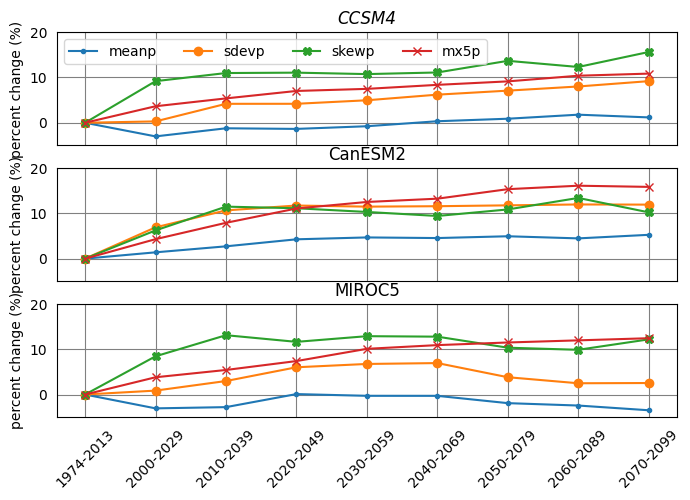

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import os
import matplotlib as mpl


CCSM4csv = '/content/drive/My Drive/Colab Notebooks/FigureParTrends/CCSM4.csv'
CanESM2csv = '/content/drive/My Drive/Colab Notebooks/FigureParTrends/CanESM2.csv'
MIROC5csv = '/content/drive/My Drive/Colab Notebooks/FigureParTrends/MIROC5.csv'
saveFILE = '/content/drive/My Drive/GEE_Downloads/Fig_Par_Trends.jpg'

gcmFiles = [CCSM4csv, CanESM2csv, MIROC5csv]
gcmLabels = ['CCSM4', 'CanESM2', 'MIROC5']
var_labels = ['mean', 'sdev', 'skew', 'mx5p']
year_labels = ['1974_2013', '2000_2029', '2010_2039', '2020_2049', '2030_2059', '2040_2069', '2050_2079', '2060_2089', '2070_2099']
year_labels = [l.replace('_', '-') for l in year_labels]


fig, ax = plt.subplots(3, 1, figsize=(8, 5))
#fig.tight_layout()


ax[0].set_title('Point-Scale Precipitation Parameters\n(annual average of monthly parameter values)', size=14, fontstyle='oblique', pad=20)


df = pd.read_csv(gcmFiles[0], index_col='par')
mean = df.loc['mean'].apply(lambda x: ((x - df.loc['mean'][0])/df.loc['mean'][0])*100.0)
sdev = df.loc['sdev'].apply(lambda x: ((x - df.loc['sdev'][0])/df.loc['sdev'][0])*100.0)
skew = df.loc['skew'].apply(lambda x: ((x - df.loc['skew'][0])/df.loc['skew'][0])*100.0)
mx5p = df.loc['mx5p'].apply(lambda x: ((x - df.loc['mx5p'][0])/df.loc['mx5p'][0])*100.0)

meanp = ax[0].plot(range(len(mean)), mean, marker='.', label='meanp')
sdevp = ax[0].plot(range(len(sdev)), sdev, marker='o', label='sdevp')
skewp = ax[0].plot(range(len(skew)), skew, marker='X', label='skewp')
mx5pp = ax[0].plot(range(len(mx5p)), mx5p, marker='x', label='mx5p')
ax[0].set_title(gcmLabels[0])
ax[0].set_ylabel('percent change (%)')
ax[0].set_ylim(-5, 20)
ax[0].set_xticks(range(len(mean)), labels=[])
ax[0].tick_params(width=0)
ax[0].legend(loc='upper left', ncols=4)
ax[0].grid(color='gray')


df = pd.read_csv(gcmFiles[1], index_col='par')
mean = df.loc['mean'].apply(lambda x: ((x - df.loc['mean'][0])/df.loc['mean'][0])*100.0)
sdev = df.loc['sdev'].apply(lambda x: ((x - df.loc['sdev'][0])/df.loc['sdev'][0])*100.0)
skew = df.loc['skew'].apply(lambda x: ((x - df.loc['skew'][0])/df.loc['skew'][0])*100.0)
mx5p = df.loc['mx5p'].apply(lambda x: ((x - df.loc['mx5p'][0])/df.loc['mx5p'][0])*100.0)

ax[1].plot(range(len(mean)), mean, marker='.')
ax[1].plot(range(len(sdev)), sdev, marker='o')
ax[1].plot(range(len(skew)), skew, marker='X')
ax[1].plot(range(len(mx5p)), mx5p, marker='x')
ax[1].set_title(gcmLabels[1])
ax[1].set_ylabel('percent change (%)')
ax[1].set_ylim(-5, 20)
ax[1].set_xticks(range(len(mean)), labels=[])
ax[1].tick_params(width=0)
ax[1].grid(color='gray')


df = pd.read_csv(gcmFiles[2], index_col='par')
mean = df.loc['mean'].apply(lambda x: ((x - df.loc['mean'][0])/df.loc['mean'][0])*100.0)
sdev = df.loc['sdev'].apply(lambda x: ((x - df.loc['sdev'][0])/df.loc['sdev'][0])*100.0)
skew = df.loc['skew'].apply(lambda x: ((x - df.loc['skew'][0])/df.loc['skew'][0])*100.0)
mx5p = df.loc['mx5p'].apply(lambda x: ((x - df.loc['mx5p'][0])/df.loc['mx5p'][0])*100.0)

ax[2].plot(range(len(mean)), mean, marker='.')
ax[2].plot(range(len(sdev)), sdev, marker='o')
ax[2].plot(range(len(skew)), skew, marker='X')
ax[2].plot(range(len(mx5p)), mx5p, marker='x')
ax[2].set_title(gcmLabels[2])
ax[2].set_ylabel('percent change (%)')
ax[2].set_ylim(-5, 20)
ax[2].set_xticks(range(len(mean)), labels=[])
ax[2].set_xticklabels(year_labels, rotation=45)
ax[2].tick_params(width=0)
ax[2].grid(color='gray')

fig.savefig(saveFILE, dpi=600, bbox_inches='tight')

